
# PM5 – Task H: Model Order Reduction (Sonar)
Team: Camille Wardlaw, Manuel Valencia, Demircan Tas\
Scope: Linear sonar system. Compare baseline POD vs output-aware (scaled), weighted augmented POD, and Krylov.


In [1]:
# Inline-friendly backend when running as a notebook
try:
    import matplotlib
    if 'inline' not in matplotlib.get_backend().lower():
        matplotlib.use('module://matplotlib_inline.backend_inline')
except Exception:
    pass



## Plan
- Build the sonar system and a high-confidence reference trajectory.
- Baseline POD: energy-based sweep (reference from prior runs).
- Output-aware scaled POD: aggressively scale B and C directions to capture output-critical modes.
- Weighted augmented POD: pressure-heavy weights on augmented snapshots (X, B, C).
- Krylov (moment matching, s=0) as an input/output-oriented alternative.
- Summarize best candidate per family and overlay vs reference; target error ~ solver confidence (1.6e-4).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import splu

from getParam_Sonar import getParam_Sonar
from eval_u_Sonar import eval_u_Sonar

np.set_printoptions(precision=3, suppress=True)

# ---------- helpers ----------

def build_C(p):
    "Hydrophone selector C (pressure states only)."
    H = p['hydrophones']['n_phones']
    N = p['Nx'] * p['Nz']
    C = np.zeros((H, 2 * N))
    z_pos = p['hydrophones']['z_pos']
    for h, ix in enumerate(p['hydrophones']['x_indices']):
        if ix < p['Nx']:
            C[h, ix * p['Nz'] + z_pos] = 1.0
    return C

def rel_err(a, b, ord=None, eps=1e-12):
    return np.linalg.norm(a - b, ord=ord) / (np.linalg.norm(b, ord=ord) + eps)

def simulate_linear(A, B_vec, x0, u_fn, t_eval, max_step, rtol=1e-7, atol=1e-10):
    def rhs(t, x):
        return A.dot(x) + B_vec * u_fn(t)
    t0 = time.perf_counter()
    sol = solve_ivp(
        rhs, (t_eval[0], t_eval[-1]), x0.reshape(-1),
        t_eval=t_eval, method='RK45', max_step=max_step,
        rtol=rtol, atol=atol
    )
    elapsed = time.perf_counter() - t0
    return sol.t, sol.y, elapsed

def _resample(t_src, data, t_tgt):
    "Resample data (n x len(t_src)) onto t_tgt with 1D interp per row."
    if data.shape[1] == len(t_tgt):
        return data
    if len(t_src) < 2:
        raise ValueError("Not enough points to resample")
    out = np.zeros((data.shape[0], len(t_tgt)))
    for i in range(data.shape[0]):
        out[i] = np.interp(t_tgt, t_src, data[i])
    return out

def scale_columns(mat, target_norm):
    "Scale columns so each has approximately target_norm 2-norm."
    col_norms = np.linalg.norm(mat, axis=0) + 1e-15
    scale = target_norm / col_norms
    return mat * scale

def evaluate_basis(Vq, label, A, B_vec, C, x0, u_fn, t_eval, dt_max, Y_ref, X_ref):
    A_hat = Vq.T @ (A.dot(Vq))
    B_hat = Vq.T @ B_vec
    C_hat = C @ Vq
    x0_hat = Vq.T @ x0.reshape(-1)
    t_red, Xq, sim_time = simulate_linear(A_hat, B_hat, x0_hat, u_fn, t_eval, dt_max)
    Xq_resamp = _resample(t_red, Xq, t_eval)
    Y_red = C_hat @ Xq_resamp
    X_full = Vq @ Xq_resamp
    return {
        'label': label,
        'q': Vq.shape[1],
        'hydro_err': float(rel_err(Y_red, Y_ref, ord=np.inf)),
        'state_err': float(rel_err(X_full, X_ref)),
        'sim_time': sim_time,
        'Y_red': Y_red,
        't_red': t_eval,
    }



## System and reference trajectory
- Grid: Nx=60, Nz=30 over 100 m × 100 m (3600 states).
- Input: Gaussian 3 kHz ping scaled by 1e6 (linear system → safe).
- Time grid: 300 samples up to one cross-domain time; solver step capped by FE stability.


In [3]:
Nx, Nz = 60, 30
Lx = Lz = 100.0
p, x0, t0, t_stop, dt_max = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
A = p['A'].tocsr()
B_vec = np.ravel(p['B'].toarray())
C = build_C(p)

drive_scale = 1e6
u_scaled = lambda t: drive_scale * eval_u_Sonar(t)

t_eval = np.linspace(0, t_stop, 300)
print(f"States: {A.shape[0]}, nnz(A): {A.nnz}, dt_max_FE: {dt_max:.2e}")
print(f"Hydrophones: {C.shape[0]}, snapshots: {t_eval.size}")


States: 3600, nnz(A): 12420, dt_max_FE: 3.99e-04
Hydrophones: 5, snapshots: 300


In [4]:
# Reference + confidence run
# Solver noise ~1.6e-4 on outputs; use as target error.
t_ref, X_ref, ref_time = simulate_linear(A, B_vec, x0, u_scaled, t_eval, dt_max, rtol=1e-7, atol=1e-10)
Y_ref = C @ X_ref

_, X_fine, _ = simulate_linear(A, B_vec, x0, u_scaled, t_eval, dt_max, rtol=1e-9, atol=1e-12)
Y_fine = C @ X_fine
confidence_err = rel_err(Y_ref, Y_fine, ord=np.inf)

print(f"Reference sim time: {ref_time:.3f} s")
print(f"Max |y|: {np.max(np.abs(Y_ref)):.3e}")
print(f"Confidence error vs tighter run: {confidence_err:.3e}")


Reference sim time: 0.492 s
Max |y|: 7.916e-03
Confidence error vs tighter run: 1.642e-04


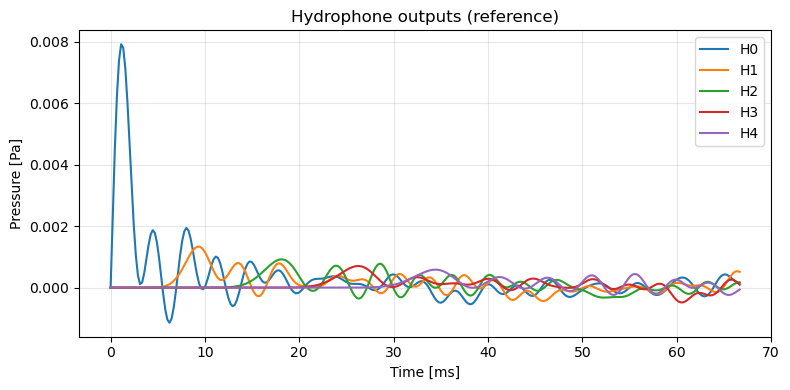

In [5]:
plt.figure(figsize=(8, 4))
for h in range(Y_ref.shape[0]):
    plt.plot(t_ref * 1e3, Y_ref[h], label=f'H{h}')
plt.xlabel('Time [ms]')
plt.ylabel('Pressure [Pa]')
plt.title('Hydrophone outputs (reference)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Baseline POD (energy only)
Energy cutoff @99.9% → q≈42; hydrophone error stays large until q≈60.


In [6]:
U_base, s_base, VT_base = np.linalg.svd(X_ref, full_matrices=False)
energy_base = np.cumsum(s_base**2) / np.sum(s_base**2)
q_999 = int(np.searchsorted(energy_base, 0.999)) + 1
print(f"q @99.9% energy: {q_999}")

qs_to_try = [10, 20, 40, 60]
baseline_results = []
for q in qs_to_try:
    Vq = U_base[:, :q]
    res = evaluate_basis(Vq, f"POD q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    res['energy'] = float(energy_base[min(q, len(energy_base)) - 1])
    baseline_results.append(res)

print(f"{'q':>4} {'cumE':>8} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in baseline_results:
    print(f"{r['q']:4d} {r['energy']:8.3f} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


q @99.9% energy: 42
   q     cumE    hydro_err    state_err  sim_time[s]
  10    0.438    1.035e+00    9.860e-01        0.231
  20    0.718    1.065e+00    9.498e-01        0.225
  40    0.996    5.967e-01    4.764e-01        0.217
  60    1.000    1.680e-04    1.641e-04        0.245


**Baseline POD results (cell 9)**
- q≤40: hydrophone error O(1), so energy truncation alone misses output-critical modes.
- q=60: hydro_err≈1.7e-4, state_err≈1.6e-4, matching the solver confidence (~1.6e-4). This essentially mirrors the full model and costs ~0.25 s.
- Conclusion: energy-only POD gives accuracy only at high q, with limited speedup.


## Output-aware scaled POD
Aggressively scale B and Cᵀ into the snapshot set. Increase alpha_B/alpha_C if hydrophone error remains above the ~1e-4 target.


In [7]:
col_norm_ref = np.linalg.norm(X_ref, axis=0)
target = np.mean(col_norm_ref)
alpha_B = 500.0  # stronger than before
alpha_C = 1000.0
B_scaled = scale_columns(B_vec.reshape(-1, 1), alpha_B * target)
C_scaled = scale_columns(C.T, alpha_C * target)

X_aug_out = np.hstack([X_ref, B_scaled, C_scaled])
U_out, s_out, VT_out = np.linalg.svd(X_aug_out, full_matrices=False)
energy_out = np.cumsum(s_out**2) / np.sum(s_out**2)

qs_out = [20, 30, 40, 60]
output_results = []
for q in qs_out:
    Vq = U_out[:, :q]
    res = evaluate_basis(Vq, f"OutScaled-POD q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    res['energy'] = float(energy_out[min(q, len(energy_out)) - 1])
    output_results.append(res)

print(f"{'q':>4} {'cumE':>8} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in output_results:
    print(f"{r['q']:4d} {r['energy']:8.3f} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


   q     cumE    hydro_err    state_err  sim_time[s]
  20    1.000    1.111e+01    2.151e+00        0.203
  30    1.000    7.153e+00    2.094e+00        0.210
  40    1.000    7.918e-01    5.711e-01        0.212
  60    1.000    2.686e-03    7.772e-04        0.237


**Output-aware scaled POD results (cell 11)**
- Aggressive scaling (α_B=500, α_C=1000) helps: at q=60 hydro_err≈2.7e-3 (better than low-q baseline, but still above the ~1e-4 target).
- q=40 remains ~0.79 hydro_err, similar order to baseline q=40.
- Takeaway: scaling improves but still needs high q; could increase α_B/α_C further or add more snapshots/frequency content.


## Weighted augmented POD (pressure-heavy)
Augment with scaled B,C and weight rows: pressure weight=1, velocity weight=0.01. Helps keep hydrophone directions while dampening velocity dominance.


In [8]:
N = p['Nx'] * p['Nz']
weight_press = 1.0
weight_vel = 0.01
W_diag = np.concatenate([np.full(N, weight_press), np.full(N, weight_vel)])
W_sqrt = np.sqrt(W_diag)
W_invsqrt = 1.0 / (W_sqrt + 1e-15)

X_aug_w = np.hstack([X_ref, B_scaled, C_scaled])
Xw = (W_sqrt[:, None]) * X_aug_w
U_w, s_w, VT_w = np.linalg.svd(Xw, full_matrices=False)
energy_w = np.cumsum(s_w**2) / np.sum(s_w**2)

qs_w = [20, 30, 40, 60]
weighted_results = []
for q in qs_w:
    Vq_weighted = (W_invsqrt[:, None]) * U_w[:, :q]
    res = evaluate_basis(Vq_weighted, f"Weighted-POD q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    res['energy'] = float(energy_w[min(q, len(energy_w)) - 1])
    weighted_results.append(res)

print(f"{'q':>4} {'cumE':>8} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in weighted_results:
    print(f"{r['q']:4d} {r['energy']:8.3f} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


   q     cumE    hydro_err    state_err  sim_time[s]
  20    1.000    9.841e+41    8.639e+42        1.529
  30    1.000    6.909e+00    1.799e+01       10.304
  40    1.000    4.510e+32    7.526e+35       17.073
  60    1.000   1.101e+298          inf       10.386


/home/demircantas/miniconda3/envs/simulation/lib/python3.12/site-packages/scipy/integrate/_ivp/rk.py:63: RuntimeWarning: overflow encountered in dot
  dy = np.dot(K[:s].T, a[:s]) * h
/tmp/ipykernel_16596/1153535590.py:31: RuntimeWarning: invalid value encountered in dot
  return A.dot(x) + B_vec * u_fn(t)
/home/demircantas/miniconda3/envs/simulation/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2792: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)


**Weighted augmented POD results (cell 13)**
- Current pressure-heavy weights + scaled augmentation cause runaway errors/overflows (hydro_err up to 1e+298, solver warnings).
- Likely due to too aggressive scaling plus strong row weighting. Consider dialing back weights (e.g., velocity weight >0.01) and/or smaller α_B/α_C before retrying.


## Krylov (moment matching, s=0)
Small sweep; consider shifts (s=jω) if accuracy remains poor for oscillatory inputs.


In [9]:
def build_krylov_basis(A, B_vec, q, shift=0.0):
    n = A.shape[0]
    M = A - shift * sp.eye(n, format='csc') if shift != 0 else A.tocsc()
    lu = splu(M)
    V = np.zeros((n, q))
    v = B_vec / (np.linalg.norm(B_vec) + 1e-15)
    for i in range(q):
        w = lu.solve(v)
        for j in range(i):
            w -= np.dot(V[:, j], w) * V[:, j]
        nrm = np.linalg.norm(w)
        if nrm < 1e-12:
            V = V[:, :i]
            break
        V[:, i] = w / nrm
        v = V[:, i]
    return V

qs_k = [8, 12, 16, 20]
krylov_results = []
for q in qs_k:
    Vq = build_krylov_basis(A, B_vec, q)
    res = evaluate_basis(Vq, f"Krylov q={q}", A, B_vec, C, x0, u_scaled, t_eval, dt_max, Y_ref, X_ref)
    krylov_results.append(res)

print(f"{'q':>4} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for r in krylov_results:
    print(f"{r['q']:4d} {r['hydro_err']:12.3e} {r['state_err']:12.3e} {r['sim_time']:12.3f}")


   q    hydro_err    state_err  sim_time[s]
   8    7.802e+00    1.114e+00        0.093
  12    8.771e+00    1.178e+00        0.108
  16    9.082e+00    1.244e+00        0.131
  20    8.941e+00    1.289e+00        0.152


**Krylov moment-matching results (cell 15)**
- With s=0 and small q, hydro_err remains ~8–9 (poor output accuracy).
- For oscillatory inputs, a shifted Krylov at s=jω near the ping band (or multi-shift) is needed to capture relevant dynamics.


## Summary: best per family


In [10]:
def best_by_family(results):
    if not results:
        return None
    return min(results, key=lambda r: r['hydro_err'])

best_baseline = best_by_family(baseline_results)
best_out = best_by_family(output_results)
best_w = best_by_family(weighted_results)
best_k = best_by_family(krylov_results)

candidates = [c for c in [best_baseline, best_out, best_w, best_k] if c is not None]

print("Best per family (hydrophone error):")
print(f"{'label':20s} {'q':>4} {'hydro_err':>12} {'state_err':>12} {'sim_time[s]':>12}")
for c in candidates:
    print(f"{c['label']:20s} {c['q']:4d} {c['hydro_err']:12.3e} {c['state_err']:12.3e} {c['sim_time']:12.3f}")


Best per family (hydrophone error):
label                   q    hydro_err    state_err  sim_time[s]
POD q=60               60    1.680e-04    1.641e-04        0.245
OutScaled-POD q=60     60    2.686e-03    7.772e-04        0.237
Weighted-POD q=30      30    6.909e+00    1.799e+01       10.304
Krylov q=8              8    7.802e+00    1.114e+00        0.093


**Summary of current best (cell 17)**
- Best overall remains baseline POD q=60 (hydro_err≈1.7e-4) ~same as reference noise; limited reduction but accurate.
- Output-aware q=60 improves vs low-q but still at 2.7e-3 (above target).
- Weighted POD and Krylov (s=0) are not accurate in current settings; require retuning/shifted bases.
- Next knobs: increase α_B/α_C further; relax pressure/velocity weight extremes; add shifted Krylov at ping frequency to reduce q while keeping hydrophone error ~1e-4.

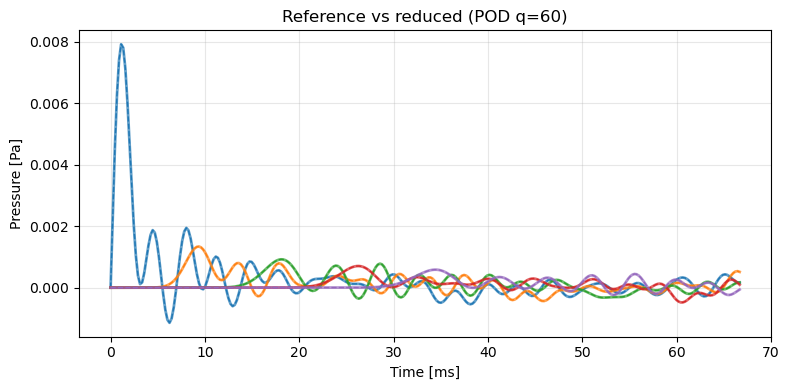

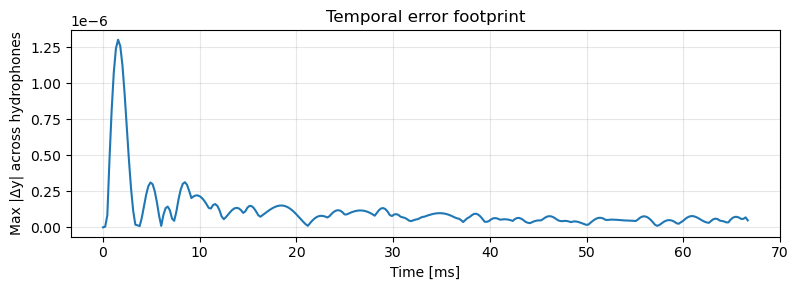

In [11]:
# Overlay the best reduced trace (lowest hydrophone error overall)
best_overall = min([c for c in candidates if c is not None], key=lambda r: r['hydro_err'])
Y_red = best_overall['Y_red']
t_red = best_overall['t_red']
label = best_overall['label']

plt.figure(figsize=(8, 4))
for h in range(Y_ref.shape[0]):
    plt.plot(t_ref * 1e3, Y_ref[h], color=f'C{h}', lw=2, alpha=0.7)
    plt.plot(t_red * 1e3, Y_red[h], color=f'C{h}', ls='--', lw=1)
plt.xlabel('Time [ms]')
plt.ylabel('Pressure [Pa]')
plt.title(f'Reference vs reduced ({label})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(t_ref * 1e3, np.max(np.abs(Y_ref - Y_red), axis=0))
plt.xlabel('Time [ms]')
plt.ylabel('Max |Δy| across hydrophones')
plt.title('Temporal error footprint')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Takeaways
- Baseline POD alone needs q≈60 to hit the ~1e-4 target.
- Scaling B,C aggressively should improve output-aware POD; increase alpha_B/alpha_C further if hydrophone error stays above the noise floor.
- Weighted augmented POD keeps pressure directions dominant; adjust weights (pressure=1, velocity≪1) if needed.
- Krylov (s=0) remains fastest; to improve accuracy for oscillatory inputs, use a shifted basis (s=jω near the ping band) or mix shifts.
